# Processing script

## 1. Imports, Options and Ingestion

In [1]:
# Imports list
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.neighbors import LocalOutlierFactor
from sklearn.decomposition import PCA

from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import AgglomerativeClustering, KMeans
from sklearn.metrics import silhouette_score

from minisom import MiniSom

from matplotlib.patches import RegularPolygon, Ellipse
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import cm, colorbar
from matplotlib import colors as mpl_colors
from matplotlib.colors import LinearSegmentedColormap

from matplotlib.lines import Line2D
import seaborn as sns

from matplotlib import __version__ as mplver

from sklearn.impute import KNNImputer
from sklearn.metrics import root_mean_squared_error

In [2]:
# Style is importantuntitled:Untitled-1.ipynb?jupyter-notebook
sns.set(style="white")

# Ensuring pandas always prints all columns and rows
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_seq_items', None)
pd.set_option('display.max_colwidth', 1000)

%config InlineBackend.figure_format = 'retina'

In [3]:
# Reading the csv data
data = pd.read_csv('../../data/data.csv')

## 2. Initial Transformations

In [4]:
_rename_dict = {
        'customer_region' : 'cust_region'
        , 'payment_method' : 'pay_method'
        , 'customer_age' : 'cust_age'
        , 'vendor_count' : 'n_vendor'
        , 'product_count' : 'n_product'
        , 'n_order' : 'n_order'
        , 'is_chain' : 'n_chain'
        , 'CUI_American' : 'american'
        , 'CUI_Asian' : 'asian'
        , 'CUI_Beverages' : 'beverages'
        , 'CUI_Cafe' : 'cafe'
        , 'CUI_Chicken Dishes' : 'chicken_dishes'
        , 'CUI_Chinese' : 'chinese'
        , 'CUI_Desserts' : 'desserts'
        , 'CUI_Healthy' : 'healthy'
        , 'CUI_Indian' : 'indian'
        , 'CUI_Italian' : 'italian'
        , 'CUI_Japanese' : 'japanese'
        , 'CUI_Noodle Dishes' : 'noodle_dishes'
        , 'CUI_OTHER' : 'other'
        , 'CUI_Street Food / Snacks' : 'street_food_snacks'
        , 'CUI_Thai' : 'thai'
}

# Rename the columns for easier reference
data.rename(columns=_rename_dict, inplace=True)

In [5]:
# Make the integer value of the customer hex values, the index. 
data['customer_id'] = data['customer_id'].apply(lambda x: int(x, 16))

# Set 'customer_id' as the index
data = data[~data['customer_id'].duplicated()].set_index('customer_id')

## 2.1. Missing Values

In [6]:
# Fill missing values for first_order
data.loc[data['first_order'].isna(), 'first_order'] = 0

In [7]:
# Fill missing values for HR_0
sum_week = data[[f"DOW_{n}" for n in range(7)]].sum(axis=1)
sum_day = data[[f"HR_{n}" for n in range(24)]].sum(axis=1)

data.loc[data['HR_0'].isna(), 'HR_0'] = (sum_week - sum_day)

## 2.2. Inconsistencies

### 2.2.1. Duplicate Values

We find 94 such rows, regarding 47 entries; and simply drop the repeats.

In [8]:
data = data.drop_duplicates()

### 2.2.2. Inconsistent Values

In [9]:
# has at least one vendor
has_vendor = data['n_vendor'] != 0 

# has at least one product
has_product = data['n_product'] != 0 

# purchase must have been made on a valid dow
some_day = (data[[f"DOW_{n}" for n in range(7)]] != 0).any(axis = 1) 

# purchase must have been made at a valid hour
some_hour = (data[[f"HR_{n}" for n in range(24)]] != 0).any(axis = 1)  

# some type of cuisine must have been ordered
some_food = (data[data.columns[9:24]] != 0).any(axis = 1) 


In [10]:
data = data[(has_vendor & has_product & some_day & some_hour & some_food)]  # And we drop these values

### 2.2.3. Weird Values

In [11]:
# Customer Region
data.loc[data['cust_region'] == '-', 'cust_region'] = '8670'
data.loc[data['cust_region'].isin(['2440', '2490']), 'cust_region'] = '2400'

# Add the feature Customer CIty
data['cust_city'] = data['cust_region'].apply(lambda x: x[0])

In [12]:
# Last Promo
data.loc[data['last_promo'] == '-', 'last_promo'] = 'NO_PROMO'

## 2.3. Data Types

In [13]:
# Tidying up datatypes
for col in data.iloc[:, 0:9]:
    if col in ['last_promo', 'pay_method']:
        data[col] = data[col].astype(object)
    else:
        data[col] = data[col].astype('Int64')

for col in data.iloc[:, 9:24]:
    data[col] = data[col].astype(float)

for col in data.iloc[:, 24:]:
    data[col] = data[col].astype('Int64')

## 3. Feature Engineering

We create lists of features for easy reference.

In [14]:
# Categorical variables
non_metric_features = ['cust_region', 'last_promo', 'pay_method', 'cust_city']

# Hour of day variables
hour_features = data.columns[31:55].to_list()

# Day of week variables
day_features = data.columns[24:31].to_list()

# Cuisine features
cuisine_features = data.columns[9:24].to_list()

# Metric variables, that are not above
metric_features = data.columns.drop(non_metric_features).drop(hour_features).drop(day_features).drop(cuisine_features).to_list()

In [15]:
# Total amount spent by customer on all types of cuisine
data['total_amt'] = data[cuisine_features].sum(axis=1)

# Number of orders made by the customer
data['n_order'] = data[day_features].sum(axis=1)

# Amount spent on average per product
data['avg_amt_per_product'] = data['total_amt'] / data['n_product']

# Amount spent on average per order
data['avg_amt_per_order'] = data['total_amt'] / data['n_order']

# Amount spent on average per vendor
data['avg_amt_per_vendor'] = data['total_amt'] / data['n_vendor']

# Total days as customer
data['days_cust'] = data['last_order'] - data['first_order']

# Average days between orders
data['avg_days_to_order'] = data['days_cust'] / data['n_order']

# Days the customer is due, according to their average days between orders
data['days_due'] = 90 - data['last_order'] + data['avg_days_to_order']

# Percentage of orders placed to restaurants that are part of a chain
data['per_chain_order'] = data['n_chain'] / data['n_order']

# And we add these tese features to the metric features list.
metric_features.extend(
    [
        'n_order'
        , 'per_chain_order'
        ,'total_amt'
        , 'avg_amt_per_order'
        , 'avg_amt_per_product'
        , 'avg_amt_per_vendor'
        , 'days_cust'
        , 'avg_days_to_order'
        , 'days_due'
    ]
)

In [16]:
# Create a mask to check if each day column is populated
mask = data[[f'DOW_{i}' for i in range(7)]] > 0

# Sum over the mask to get the count of days with purchases for each row
data.loc[:, 'n_days_week'] = mask.sum(axis=1)

# Updating the list of metric features
metric_features.append('n_days_week')

In [17]:
# Create a mask to check if each hour column is populated
mask = data[hour_features] > 0

# Sum over the mask to get the count of hours with purchases for each row
data.loc[:, 'n_times_day'] = mask.sum(axis=1)

# Updating the list of metric features
metric_features.append('n_times_day')

In [18]:
# Flag customers who have purchased in more than one day
data['regular'] = (data['days_cust'] != 0)

non_metric_features.append('regular')

In [19]:
# Create a mask where values are greater than zero (indicating an order)
mask = data[cuisine_features] > 0

# # Use mask to get the ordered cuisines for each row
# data.loc[:, 'ordered_cuisines'] = mask.apply(lambda row: [cuisine for cuisine, ordered in row.items() if ordered], axis=1)

# # Updating the non_metric_features_list
# non_metric_features.append('ordered_cuisines')

# Use mask to get the number of cuisines for each row
data.loc[:, 'n_cuisines'] = mask.sum(axis=1)

# Updating the metric_features_list
metric_features.append('n_cuisines')

In [20]:
# Dropping specified columns and getting remaining columns as a list
targets = data.drop(columns=[
    'cust_age'
    , 'first_order'
    , 'last_order'
    , 'days_cust'
    , 'days_due'
    , 'avg_days_to_order'
    , 'per_chain_order'
    , 'cust_region'
    , 'cust_city'
    , 'last_promo'
    , 'pay_method'
    # , 'ordered_cuisines'
    , 'n_cuisines'
    , 'regular'
] + hour_features + day_features).columns.tolist()

# Initialize an empty DataFrame to store log-transformed columns
log_transformed = pd.DataFrame()

# Apply log1p to each column in targets and add it to log_transformed with the prefix 'log_'
for col in targets:
    log_transformed[f"log_{col}"] = np.log1p(data[col])

# We create a list of log_features to assist us in our exploration
log_features = log_transformed.columns.tolist()

# Concatenate the original DataFrame with the new log-transformed DataFrame
data = pd.concat([data, log_transformed], axis=1)

In [21]:
# Initialize dictionaries for feature groups with flags and relevant columns
feature_groups = {
    'foodie': ['n_vendor', 'n_product', 'n_order', 'n_cuisines'],
    'gluttonous': ['avg_amt_per_order', 'total_amt', 'n_chain'],
    'loyal': ['avg_amt_per_vendor'] + cuisine_features
}


# Create columns to hold the flags for each feature group
data['foodie_flag'] = 0
data['gluttonous_flag'] = 0
data['loyal_flag'] = 0

# Function to calculate IQR bounds
def calculate_bounds(series):
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return lower_bound, upper_bound

# Assign flags for each feature group
for group, features in feature_groups.items():
    for feature in features:
        log_feature = f"log_{feature}"
        
        if feature == 'n_cuisines':
            log_feature = feature
        
        lower_bound, upper_bound = calculate_bounds(data.loc[(data['regular'] == 1) & (data[feature] > 0), log_feature])
        
        # Mark outliers for each group
        if group == 'foodie':
            data.loc[data['regular'] == 1, 'foodie_flag'] |= (
                data.loc[data['regular'] == 1, log_feature] > upper_bound
            ).astype(int)
        elif group == 'gluttonous':
            data.loc[data['regular'] == 1, 'gluttonous_flag'] |= (
                data.loc[data['regular'] == 1, log_feature] > upper_bound
            ).astype(int)
        elif group == 'loyal':
            data.loc[data['regular'] == 1, 'loyal_flag'] |= (
                data.loc[data['regular'] == 1, log_feature] > upper_bound
            ).astype(int)

# Display results
for group in ['foodie_flag', 'gluttonous_flag', 'loyal_flag']:
    print(f"Number of customers flagged as {group.split('_')[0]}:", data[group].sum())

non_metric_features.extend([
    'foodie_flag'
    ,'gluttonous_flag'
    ,'loyal_flag'
])

Number of customers flagged as foodie: 2852
Number of customers flagged as gluttonous: 647
Number of customers flagged as loyal: 467


In [22]:
def top_n(row, col_list, n):
    # Sort the specified columns in descending order
    sorted_row = row[col_list].sort_values(ascending=False)

    # Get the unique sorted values
    unique_sorted_values = sorted_row.unique()

    # Ensure there are enough unique values to determine the n-th largest
    if len(unique_sorted_values) >= n:
        nth_value = unique_sorted_values[n - 1]  # Get the n-th largest unique value

        # If the n-th value is 0, return None
        if nth_value == 0:
            return None
        
        # If n > 1, check for uniqueness against the (n-1)-th largest
        if n > 1:
            prev_value = unique_sorted_values[n - 2]  # (n-1)-th largest unique value
            # If nth_value is equal to the (n-1)-th value, we don't want to return it
            if nth_value == prev_value:
                return None
        
        # Return the index of the n-th largest value
        return sorted_row[sorted_row == nth_value].index[0]

    # Return None if conditions are not met
    return None

In [23]:
data['top_cuisine'] = data.apply(top_n, col_list=cuisine_features, n=1, axis=1)

non_metric_features.append('top_cuisine')

In [24]:
# Average amount spent per day as customer
data['avg_amt_per_day'] = np.round(data['total_amt'] / data['days_cust'], 4)

# Average number of products ordered per day as customer
data['avg_product_per_day'] = np.round(data['n_product'] / data['days_cust'], 4)

# Average number of orders per day as customer
data['avg_order_per_day'] = np.round(data['n_order'] / data['days_cust'], 4)

metric_features.extend([
    'avg_amt_per_day'
    ,'avg_product_per_day'
    ,'avg_order_per_day'
])

## 4. Preprocessing

Before starting the preprocessing efforts, there are some customers that can be perceived as outliers, namely the ones that were flagged as part of a group or non-regulars. Therefore, we create an auxiliary dataframe excluding these, which we will use in a fashion resembling a train-test split, where these are the training data.

In [25]:
# Create dataframe with only customers which are regular and do not belong to another group
aux_df = data[data['regular'] == 1]

### 4.1. Outliers

Based on the boxplots of the EDA part of the project, we can filter our dataset using the following conditions.

In [26]:
og_rows = data.shape[0]

In [27]:
def compute_percentile_bounds(reference_data, filters):
    """
    Compute percentile bounds for the given filters using the reference dataset.

    :param reference_data: DataFrame used to compute the percentiles.
    :param filters: Dictionary of column names and (lower_percentile, upper_percentile).
    :return: Dictionary with column names and the corresponding (lower_bound, upper_bound).
    """
    bounds = {}
    
    for col, percentiles in filters.items():
        if col not in reference_data.columns:
            raise ValueError(f"Column '{col}' not found in the reference DataFrame.")

        lower_percentile, upper_percentile = percentiles
        lower_bound = reference_da.ta[col].quantile(lower_percentile) if lower_percentile is not None else None
        upper_bound = reference_data[col].quantile(upper_percentile) if upper_percentile is not None else None
        bounds[col] = (lower_bound, upper_bound)

    return bounds

def filter_by_bounds(data, bounds):
    """
    Filter the data using precomputed bounds.

    :param data: DataFrame to be filtered.
    :param bounds: Dictionary with column names and the corresponding (lower_bound, upper_bound).
    :return: Filtered DataFrame.
    """
    conditions = []

    for col, (lower_bound, upper_bound) in bounds.items():
        if col not in data.columns:
            raise ValueError(f"Column '{col}' not found in the DataFrame.")

        if lower_bound is not None:
            conditions.append(data[col] >= lower_bound)
        if upper_bound is not None:
            conditions.append(data[col] <= upper_bound)

    if conditions:
        combined_condition = conditions[0]
        for condition in conditions[1:]:
            combined_condition &= condition
        return data[combined_condition]

    return data

# Example Usage:
# Compute bounds using dataset a
defined_filters = {
    **{col: (None, 0.999) for col in aux_df.columns if 'log' in col}
}
percentile_bounds = compute_percentile_bounds(aux_df, defined_filters)

# Filter dataset b using the computed bounds
data = filter_by_bounds(data, percentile_bounds)


In [28]:
print('Percentage of data kept after removing outliers:', 100 * np.round(data.shape[0] / og_rows, 4))

Percentage of data kept after removing outliers: 94.95


Let us recheck the boxplots

### 4.2. Missing Values

In [29]:
# Recreate dataframe with only customers which are regular and do not belong to another group
aux_df = data[data['regular'] == 1]

There are missing values for 'cust_age', which will be imputed using a strategy to be determined next.

In [30]:
data.loc[data['cust_age'].isna(), 'cust_age'] = aux_df['cust_age'].mean().astype('int')

## 4.3. Categorical Encoding

In [31]:
# Recreate the auxiliary dataframe
aux_df = data[data['regular'] == 1]

In [32]:
ohe = OneHotEncoder(sparse_output=False).set_output(transform='pandas')
# ohe.fit(aux_df[non_metric_features[:4]])
ohe_df = ohe.fit_transform(data[non_metric_features[:4]])

ohe_feat_names = ohe.get_feature_names_out()

In [33]:
data = pd.concat([data.drop(columns=non_metric_features[:4]), ohe_df], axis=1)

In [34]:
regulars = data[data['regular'] == 1].copy(deep=True)

### 4.4. Data Standardization

In [35]:
scaler = StandardScaler().set_output(transform='pandas')
regulars = pd.concat([scaler.fit_transform(regulars.drop(columns=list(ohe_feat_names) + non_metric_features[4:])), regulars[list(ohe_feat_names) + non_metric_features[4:]]], axis=1)

### 4.5. Multidimensional Outliers

Now, Local Outlier Factor can be applied to remove the multidimensional outliers, since the data is scaled.

In [36]:
regulars_og = regulars.shape[0]

In [37]:
lof_std = LocalOutlierFactor(n_neighbors=5)

outlier_predictions = lof_std.fit_predict(regulars.drop(columns=list(ohe_feat_names) + non_metric_features[4:]))

# Mark outliers
regulars['Outlier'] = np.where(outlier_predictions == -1, True, False)

# Remove outliers
regulars = regulars[regulars['Outlier'] == False].drop(columns=['Outlier'])

### 4.6. Feature Selection

We will perform PCA with the variables avg_amt_per_day, avg_product_per_day, avg_order_per_day, n_product and n_order - in order to reduce dimensionality and assess if the resulting principal components are of any help.

In [38]:
pca = PCA(random_state=20)
pca_feat = pca.fit_transform(regulars[['avg_amt_per_day', 'avg_product_per_day', 'avg_order_per_day', 'n_product', 'n_order']])

In [39]:
# Get the eigenvalues (explained variance)
explained_variance = pca.explained_variance_

# Get the explained variance ratio
explained_variance_ratio = pca.explained_variance_ratio_

# get the cumulative explained variance ratio 
cumulative_explained_variance_ratio = np.cumsum(explained_variance_ratio)

# Combine into a dataframe
pca_results = pd.DataFrame(
    {
        "Eigenvalue": explained_variance,
        "Difference": np.insert(np.diff(explained_variance), 0, 0),
        "Proportion": explained_variance_ratio,
        "Cumulative": cumulative_explained_variance_ratio
    },
        index=range(1, pca.n_components_ + 1)
)

pca_results

,Eigenvalue,Difference,Proportion,Cumulative
1,2.706068,0.000000,0.565395,0.565395
2,1.827410,-0.878658,0.381812,0.947207
3,0.193551,-1.633859,0.040440,0.987647
4,0.037580,-0.155971,0.007852,0.995499
5,0.021543,-0.016037,0.004501,1.000000


In [40]:
# Perform PCA again with the number of principal components you want to retain
pca = PCA(n_components=3, random_state=20)
pca_feat = pca.fit_transform(regulars[['avg_amt_per_day', 'avg_product_per_day', 'avg_order_per_day', 'n_product', 'n_order']])
pca_feat_names = [f"PC{i}" for i in range(pca.n_components_)]

# remember index=df_pca.index
pca_df = pd.DataFrame(pca_feat, index=regulars.index, columns=pca_feat_names)  

In [41]:
# Reassigning df to contain pca variables
df_pca = pd.concat([regulars, pca_df], axis=1)

In [42]:
loadings = df_pca[['avg_amt_per_day', 'avg_product_per_day', 'avg_order_per_day', 'n_product', 'n_order'] + pca_feat_names].corr().loc[['avg_amt_per_day', 'avg_product_per_day', 'avg_order_per_day', 'n_product', 'n_order'], pca_feat_names]

In [43]:
df_pca.drop(columns='PC2', inplace=True)

In [44]:
df_pca.rename(columns={'PC0': 'transaction_volume', 'PC1': 'interaction_rate'}, inplace=True)

# End of Processing File

In [45]:
log_cuisine_features = [
    'log_american', 'log_asian', 'log_beverages', 'log_cafe', 
       'log_chinese', 'log_desserts', 'log_healthy', 'log_indian',
       'log_italian', 'log_japanese', 'log_noodle_dishes', 'log_other',
       'log_street_food_snacks', 'log_thai'
]

log_features = [
    'log_total_amt', 'log_n_order',
    'log_avg_amt_per_product', 'log_avg_amt_per_order', 'log_chicken_dishes',
    'log_avg_amt_per_vendor', 'log_n_days_week', 'log_n_times_day',
    'avg_amt_per_day', 'avg_product_per_day', 'avg_order_per_day'
]
cuisine_factors = df_pca[log_cuisine_features].copy()

In [54]:
from sklearn.decomposition import SparsePCA
from sklearn.preprocessing import StandardScaler

# Apply Sparse PCA to extract sparse components
n_components = 3  # Number of components you want to extract
sparse_pca = SparsePCA(n_components=n_components, random_state=0)

# Fit the Sparse PCA model
sparse_pca.fit(cuisine_factors)

# Get the Sparse PCA components
components = sparse_pca.components_

# Get the top labels for Sparse PCA components (top values in each component)
top_labels = {}
for i, component in enumerate(components):
    sorted_indices = np.argsort(component)[::-1]  # Sort in descending order
    top_features = cuisine_factors.columns[sorted_indices][:3]  # Top 3 features
    top_labels[f'Component_{i+1}'] = top_features

# Display top labels for each Sparse PCA component
print("\nTop Labels for Each Sparse PCA Component:")
for component, labels in top_labels.items():
    print(f"{component}: {', '.join(labels)}")
    
# Convert the components into a DataFrame with cuisines as columns and components as rows
components_df = pd.DataFrame(components, columns=log_cuisine_features, index=[f"Component_{i+1}" for i in range(components.shape[0])])

# Display the DataFrame
print("\nSparse PCA Components DataFrame:")
components_df.T


Top Labels for Each Sparse PCA Component:
Component_1: log_asian, log_street_food_snacks, log_desserts
Component_2: log_noodle_dishes, log_chinese, log_other
Component_3: log_cafe, log_japanese, log_healthy

Sparse PCA Components DataFrame:


,Component_1,Component_2,Component_3
log_american,0.000000,-0.245774,0.184393
log_asian,0.457687,-0.148661,0.158049
log_beverages,0.265743,0.287718,-0.059643
log_cafe,-0.158520,-0.060812,0.558616
log_chinese,0.000000,0.530722,0.110857
log_desserts,0.304618,0.056816,0.117170
log_healthy,0.000000,0.000000,0.472095
log_indian,-0.277486,-0.009674,0.000000
log_italian,-0.409103,-0.285937,0.000000
log_japanese,0.077683,0.000000,0.512027


In [55]:
# Transform the original data using the fitted Sparse PCA model
transformed_data = sparse_pca.transform(cuisine_factors)

# Convert the transformed data into a DataFrame for better interpretability
# Each row corresponds to a sample, and columns are the Sparse PCA components
transformed_df = pd.DataFrame(
    transformed_data,
    columns=[f"Component_{i+1}" for i in range(n_components)],
    index=cuisine_factors.index  # Keep the original indices for reference
)

# Display the transformed data
print("\nTransformed Data (Sparse PCA Scores):")
print(transformed_df.head())



Transformed Data (Sparse PCA Scores):
               Component_1  Component_2  Component_3
customer_id                                         
118371798366     -1.392287    -0.250760    -1.131596
400089128395      0.356173    -0.820501    -0.364545
1060080106083    -0.244072    -0.600149    -0.674967
103287041752     -0.432021    -0.452494    -0.761010
338018592517      0.876308    -0.983318    -0.116983


In [56]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
import itertools

# Assuming df_pca and cuisine_features are defined
data = transformed_df.copy()

# Step 1: Fit a Gaussian Mixture Model
n_components = 3 # Adjust this based on your data or use BIC/AIC to find the optimal number of components
gmm = GaussianMixture(n_components=n_components, random_state=42)
gmm_labels = gmm.fit_predict(data)

# Add GMM labels to the DataFrame
data['cluster'] = gmm_labels

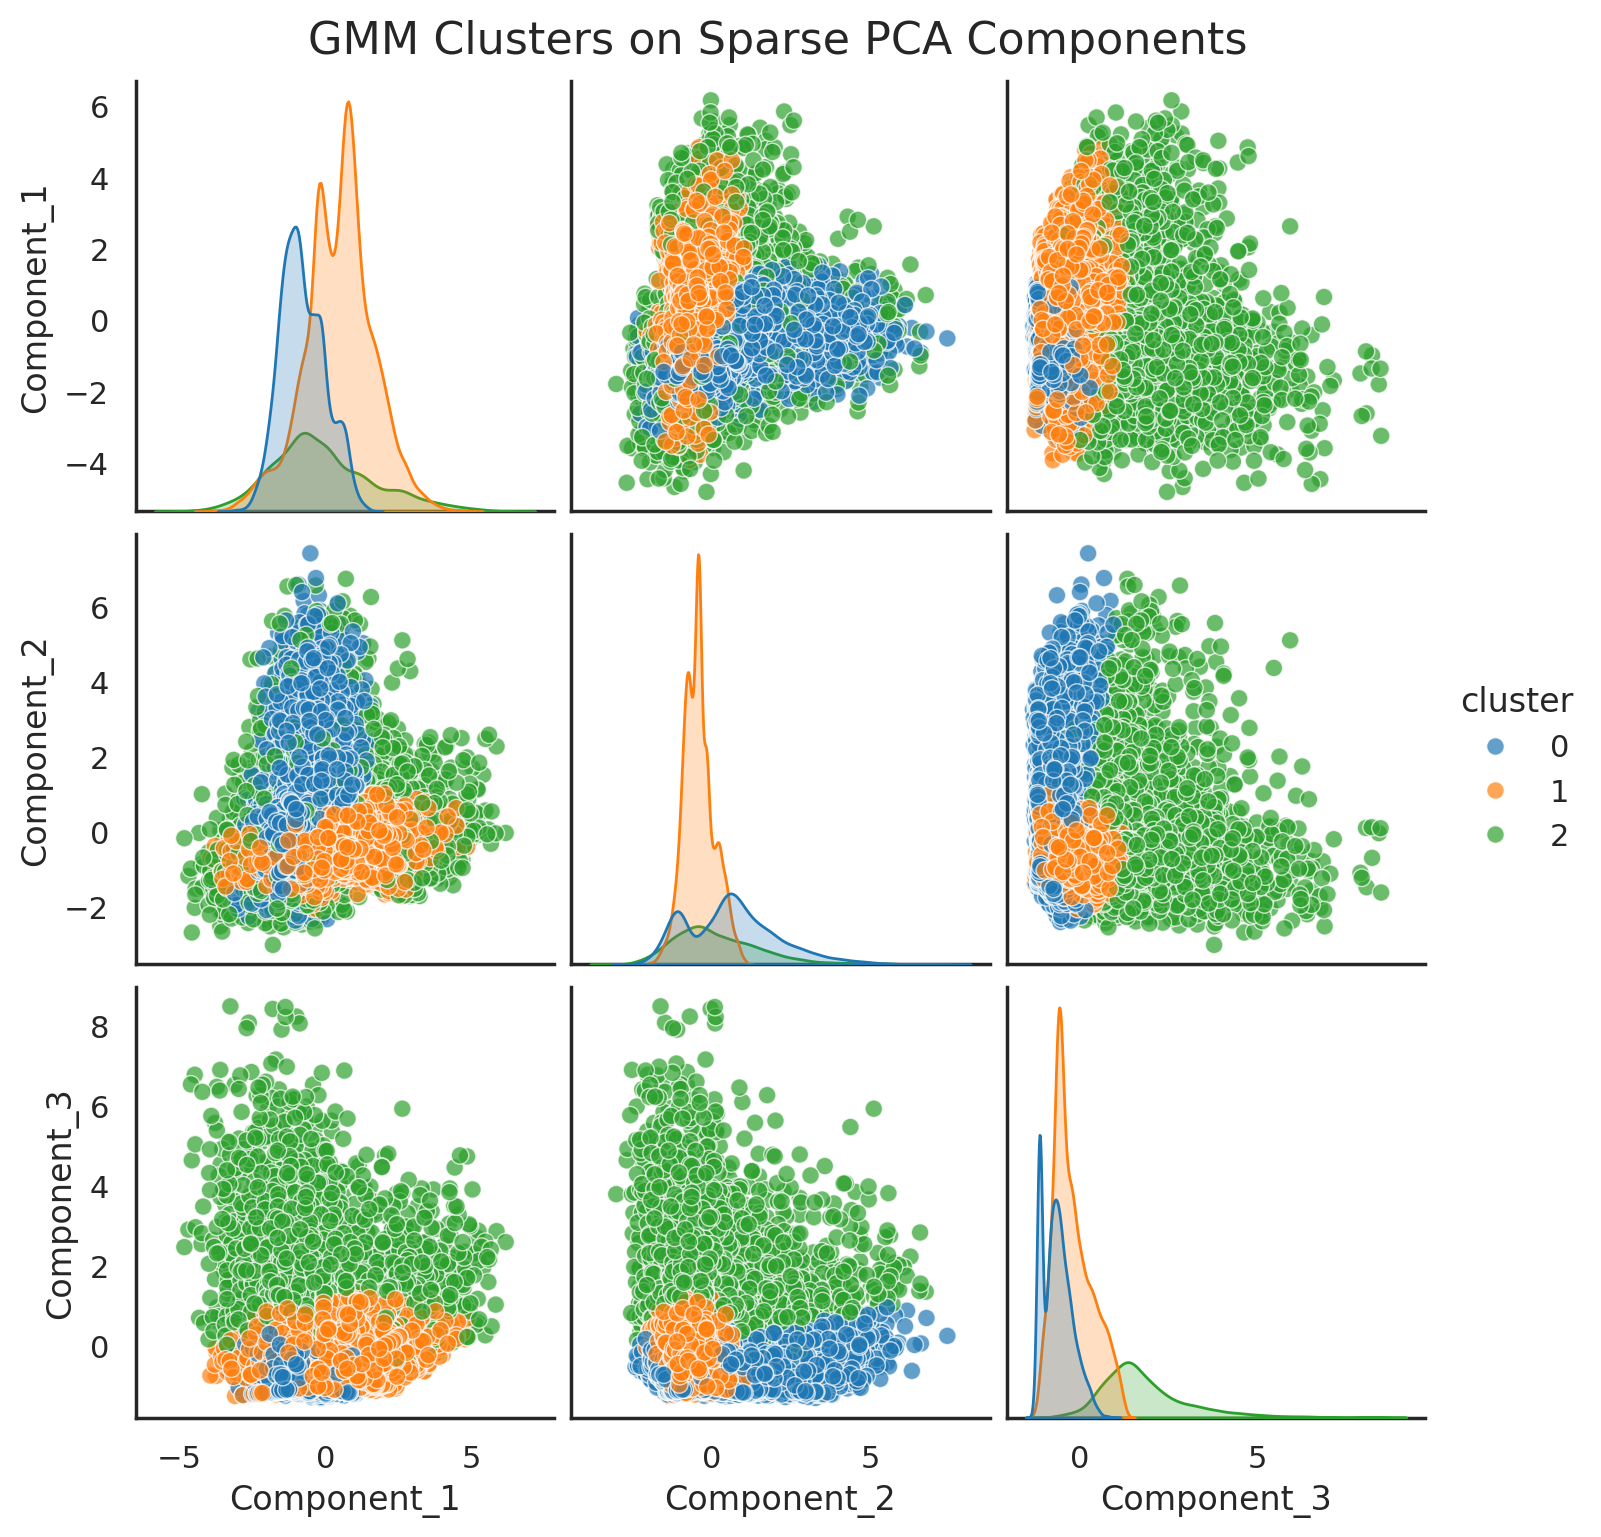

In [57]:
import seaborn as sns
import matplotlib.pyplot as plt

# Pairplot of GMM clusters
sns.pairplot(
    data,
    vars=[f"Component_{i+1}" for i in range(n_components)],  # Select PCA components
    hue='cluster',  # Color by cluster
    palette='tab10',  # Use a distinct color palette
    diag_kind='kde',  # Include KDE plots on the diagonal
    plot_kws={'alpha': 0.7, 's': 40},  # Adjust scatter plot transparency and size
)

# Add a title
plt.suptitle("GMM Clusters on Sparse PCA Components", y=1.02, fontsize=16)

# Show the plot
plt.show()
